## Dependancies

In this section we install and import all the dependancies necessary for the training process.

In [ ]:
!apt-get update -qq && apt-get install -qq libfluidsynth1 fluid-soundfont-gm build-essential libasound2-dev libjack-dev
!pip install -qU pyfluidsynth pretty_midi
!pip install music21
!pip install pypianoroll

E: Package 'libfluidsynth1' has no installation candidate
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 50.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.8 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import os
import shutil
import glob
import numpy as np
import pandas as pd
import pretty_midi
import pypianoroll
import tables
from music21 import converter, instrument, note, chord, stream
import music21
import librosa
import librosa.display
import matplotlib.pyplot as plt
import json
import IPython.display
from datetime import datetime
import random

import torch
import torch.nn as nn
from torch.nn import functional as F
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

from tqdm.notebook import tqdm, trange

import random
import itertools
root_dir = '/content/drive/MyDrive/ColabNotebooks/AsItSounds'
local_dir = "/content/"
data_dir = root_dir + '/Lakh Piano Dataset/lpd_5/lpd_5_cleansed'
music_dataset_lpd_dir = root_dir + '/Music Dataset/midis/lmd_matched'

Using device: cuda


These cells are used to download the preprocessed tensors (previously generated in "VAE_Preprocessing" notebook). They will try to actually download them from the drive links, but there is an option to make a copy from drive in case the download fails.

In [4]:
!gdown 13cuoFQLlb_NErTttHj9cqvsTnXbLcRKu # to download 'full_pianorolls.pt'

Downloading...
From (original): https://drive.google.com/uc?id=13cuoFQLlb_NErTttHj9cqvsTnXbLcRKu
From (redirected): https://drive.google.com/uc?id=13cuoFQLlb_NErTttHj9cqvsTnXbLcRKu&confirm=t&uuid=e8200100-47e8-4cd7-a585-f7d76f2b2bc6
To: /content/full_pianorolls.pt
100% 11.2G/11.2G [01:07<00:00, 167MB/s]


If the latter cell fails, you could run the lower one to attempt a copy from a Google Drive.

In [ ]:
!cp -v '/content/drive/MyDrive/ColabNotebooks/AsItSounds/Lakh Piano Dataset/full_pianorolls.pt' '/content/'

'/content/drive/MyDrive/Colab Notebooks/AsItSounds/Lakh Piano Dataset/full_pianorolls.pt' -> '/content/full_pianorolls.pt'


In [5]:
!gdown 1-2ttvr3xG0VUympyMCFgqIV3KslNjq4Q # per scaricare 'full_lengths.pt'

Downloading...
From: https://drive.google.com/uc?id=1-2ttvr3xG0VUympyMCFgqIV3KslNjq4Q
To: /content/full_lengths.pt
100% 173k/173k [00:00<00:00, 146MB/s]


In [6]:
# Loading
combined_pianorolls = torch.load(os.path.join(local_dir, 'full_pianorolls.pt'))
pianoroll_lengths = torch.load(os.path.join(local_dir, 'full_lengths.pt'))
pianoroll_lengths = pianoroll_lengths.numpy()
pianoroll_cum_lengths = pianoroll_lengths.cumsum()
print(combined_pianorolls.shape)
print(combined_pianorolls.max(), combined_pianorolls.min())

torch.Size([5, 17501240, 128])
tensor(127, dtype=torch.uint8) tensor(0, dtype=torch.uint8)


The following cells are just a test of display to see if the datas are loaded correctly.

[<Axes: xlabel='time (beat)', ylabel='Piano\n\npitch'>,
 <Axes: xlabel='time (beat)', ylabel='Guitar\n\npitch'>,
 <Axes: xlabel='time (beat)', ylabel='Bass\n\npitch'>,
 <Axes: xlabel='time (beat)', ylabel='Strings\n\npitch'>,
 <Axes: xlabel='time (beat)', ylabel='Drums\n\npitch'>]

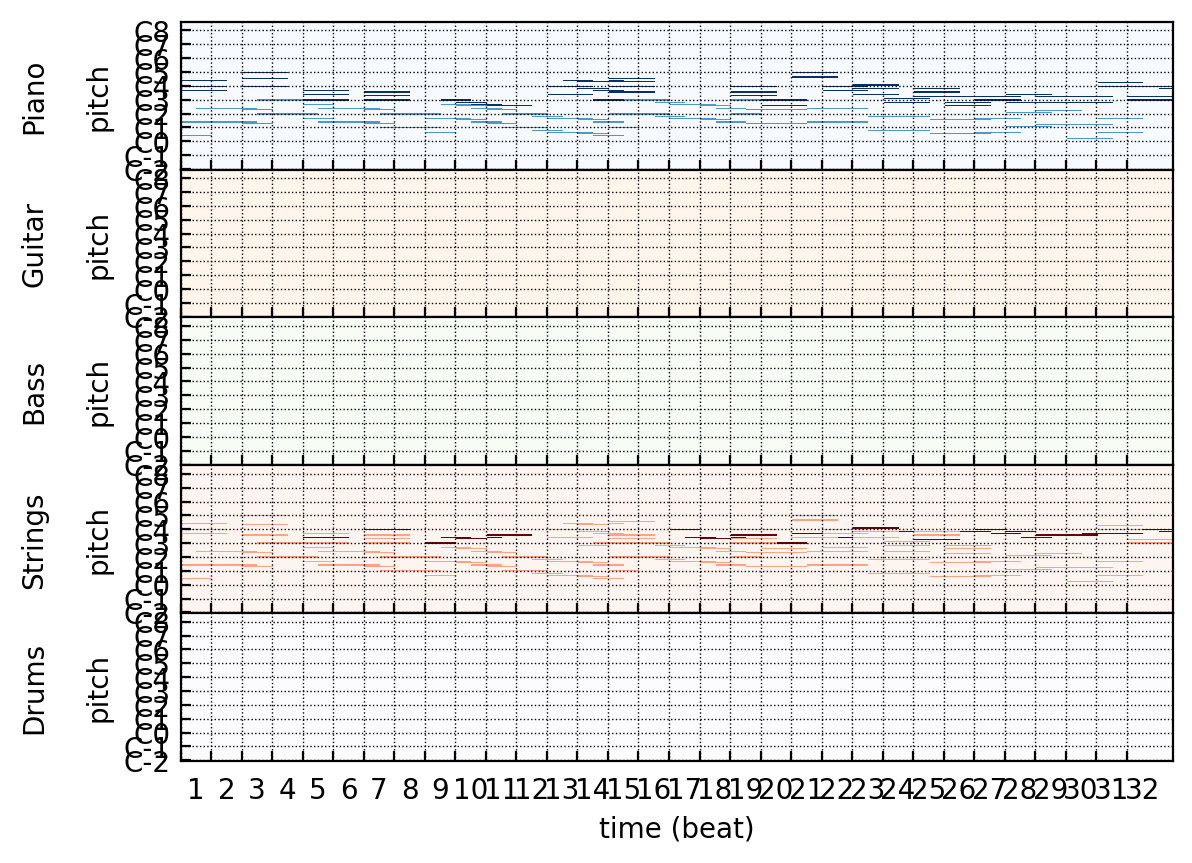

In [7]:
one_song = combined_pianorolls[:,:65,:]
one_song = one_song * 127
one_piano_track = pypianoroll.StandardTrack(name = 'Piano', program = 0, is_drum = False, pianoroll = one_song[0, :, :].detach().cpu().numpy())
one_guitar_track = pypianoroll.StandardTrack(name = 'Guitar', program = 24, is_drum = False, pianoroll = one_song[1, :, :].detach().cpu().numpy())
one_bass_track = pypianoroll.StandardTrack(name = 'Bass', program = 32, is_drum = False, pianoroll = one_song[2, :, :].cpu().detach().numpy())
one_strings_track = pypianoroll.StandardTrack(name = 'Strings', program = 48, is_drum = False, pianoroll = one_song[3, :, :].cpu().detach().numpy())
one_drums_track = pypianoroll.StandardTrack(name = 'Drums', is_drum = True, pianoroll = one_song[4, :, :].cpu().detach().numpy())
one_song_multitrack = pypianoroll.Multitrack(name = 'Generated', resolution = 2, tracks = [one_piano_track, one_guitar_track, one_bass_track, one_strings_track, one_drums_track])
one_song_multitrack.plot()


In [ ]:
# Remake the list of pianorolls - ensuring all songs are multiple of 32
pianorolls_list = []
for i in range(len(pianoroll_cum_lengths) - 1):
  length = pianoroll_cum_lengths[i+1] - pianoroll_cum_lengths[i]
  # Get the nearest multiple of 32
  length_multiple = length - (length % 32)
  pianoroll = combined_pianorolls[:, pianoroll_cum_lengths[i]:(pianoroll_cum_lengths[i] + length_multiple), :]
  pianorolls_list.append(pianoroll)

In [ ]:
len(pianorolls_list)

21424

## Creating Music Dataset

In this section, various dataset classes will be created to handle datas in the training process.

In [ ]:
# Creating dataset and dataloader
from torch.utils.data import Dataset, DataLoader

In [ ]:
# Dataset which only returns sequences which are multiples of 32
class CombinedDataset(Dataset):
  def __init__(self, pianorolls, instrument_id):
    self.data = pianorolls
    self.length = int(pianorolls.size(1) / 32)
    self.instrument_id = instrument_id

  def __getitem__(self, index):
    sequence = self.data[self.instrument_id, (index * 32):((index+1) * 32), :]
    return sequence

  def __len__(self):
    return self.length

In [ ]:
# Melody-conditional dataset NEW - returns BOTH the previous harmony, and current melody, and current harmony
# only outputs samples with all tracks non-empty
class ConditionalDataset(Dataset):
  def __init__(self, list_of_sequences, dataset_length = 32 * 1000, seq_length = 50, instrument = 'guitar'):

    self.data = list_of_sequences
    self.n_songs = len(list_of_sequences)
    self.seq_length = seq_length
    self.length = dataset_length
    self.instrument = instrument

  def __getitem__(self, index):
    # Choose a random song id
    valid_sequence = False

    while valid_sequence == False:
      song_id = random.randint(0, self.n_songs - 1)
      song_length = self.data[song_id].size()[1]

      if song_length > (self.seq_length * 2 + 5):

        # Choose a random start window
        start_time = random.randint(0, song_length - self.seq_length * 2 - 2)
        start_time = start_time - (start_time % 32)

        # train_sequence: 1 (piano) x seq_length x 128
        piano_sequence = self.data[song_id][0, (start_time + self.seq_length):(start_time + self.seq_length * 2), :]

        if self.instrument == 'guitar':
          past_sequence = self.data[song_id][1, start_time:(start_time + self.seq_length), :]
          target_sequence = self.data[song_id][1, (start_time + self.seq_length):(start_time + self.seq_length * 2), :]
        elif self.instrument == 'bass':
          past_sequence = self.data[song_id][2, start_time:(start_time + self.seq_length), :]
          target_sequence = self.data[song_id][2, (start_time + self.seq_length):(start_time + self.seq_length * 2), :]
        elif self.instrument == 'strings':
          past_sequence = self.data[song_id][3, start_time:(start_time + self.seq_length), :]
          target_sequence = self.data[song_id][3, (start_time + self.seq_length):(start_time + self.seq_length * 2), :]
        elif self.instrument == 'drums':
          past_sequence = self.data[song_id][4, start_time:(start_time + self.seq_length), :]
          target_sequence = self.data[song_id][4, (start_time + self.seq_length):(start_time + self.seq_length * 2), :]
        else:
          past_sequence = None
          target_sequence = None

        if piano_sequence.sum() != 0 and past_sequence.sum() != 0 and target_sequence.sum() != 0:
          valid_sequence = True
        else:
          if random.random() < 0.1:
            valid_sequence = True

    return piano_sequence, past_sequence, target_sequence
  def __len__(self):
    return self.length

In [ ]:
# Melody prediction dataset - predict the next melody given the current melody
class MelodyDataset(Dataset):
  def __init__(self, list_of_sequences, dataset_length = 32 * 10000, seq_length = 50):

    # Don't normalize anymore since it was done earlier
    self.data = list_of_sequences
    self.n_songs = len(list_of_sequences)
    self.seq_length = seq_length
    self.length = dataset_length

  def __getitem__(self, index):
    # Choose a random song id
    valid_sequence  = False
    while valid_sequence == False:
      song_id = random.randint(0, self.n_songs - 1)
      song_length = self.data[song_id].size()[1]

      if song_length > (self.seq_length * 2 + 5):
        # Choose a random start window
        start_time = random.randint(0, song_length - self.seq_length * 2 - 2)
        start_time = start_time - (start_time % 32)
        # train_sequence: 1 (piano) x seq_length x 128
        train_sequence = self.data[song_id][0, start_time:(start_time + self.seq_length), :]
        # target_sequence: 1 (piano) x seq_length x 128
        target_sequence = self.data[song_id][0, (start_time + self.seq_length):(start_time + self.seq_length * 2), :]

        valid_sequence = True

    return train_sequence, target_sequence

  def __len__(self):
    return self.length

## VAE Execution

In [ ]:
# @title VAE Helper Functions

def kl_q_p(zs, phi):
    """Given [b,n,k] samples of z drawn from q, compute estimate of KL(q||p).
    phi must be size [b,k+1]

    This uses mu_p = 0 and sigma_p = 1, which simplifies the log(p(zs)) term to
    just -1/2*(zs**2)
    """
    b, n, k = zs.size()
    mu_q, log_sig_q = phi[:,:-1], phi[:,-1]
    log_p = -0.5*(zs**2)
    log_q = -0.5*(zs - mu_q.view(b,1,k))**2 / log_sig_q.exp().view(b,1,1)**2 - log_sig_q.view(b,1,-1)
    # Size of log_q and log_p is [b,n,k]. Sum along [k] but mean along [b,n]
    return (log_q - log_p).sum(dim=2).mean(dim=(0,1))

def log_p_x(x, mu_xs, sig_x):
    """Given [batch, ...] input x and [batch, n, ...] reconstructions, compute
    pixel-wise log Gaussian probability

    Sum over pixel dimensions, but mean over batch and samples.
    """
    b, n = mu_xs.size()[:2]
    # Flatten out pixels and add a singleton dimension [1] so that x will be
    # implicitly expanded when combined with mu_xs
    x = x.reshape(b, 1, -1)
    _, _, p = x.size()
    squared_error = (x - mu_xs.view(b, n, -1))**2 / (2*sig_x**2)

    # Size of squared_error is [b,n,p]. log prob is by definition sum over [p].
    # Expected value requires mean over [n]. Handling different size batches
    # requires mean over [b].
    return -(squared_error + torch.log(sig_x)).sum(dim=2).mean(dim=(0,1))

def rsample(phi, n_samples):
    """Sample z ~ q(z;phi)
    Ouput z is size [b,n_samples,K] given phi with shape [b,K+1]. The first K
    entries of each row of phi are the mean of q, and phi[:,-1] is the log
    standard deviation
    """
    b, kplus1 = phi.size()
    k = kplus1-1
    mu, sig = phi[:, :-1], phi[:,-1].exp()
    eps = torch.randn(b, n_samples, k, device=phi.device)
    return eps*sig.view(b,1,1) + mu.view(b,1,k)

The following cell defines a **Convolutive VAE** architecture that will embody the core of our training. Specifically, it is an architecture that tries to learn to compress a music bar into a vector in some latent space that would represent it without minor losses in terms of information.

The architecture is basically made as a **convolutional encoder**, following a **linear layer** which represents the latent vector, and finally a **deconvolutional decoder**.

In [ ]:
class ConvVAE(nn.Module):
    def __init__(self, K, num_filters=32, filter_size=5):
        super(ConvVAE, self).__init__()

        # Define the recognition model (encoder or q) part
        # Input size: num_channels (1) x seq_length (32) x n_pitches (128)
        self.q_conv_1 = nn.Conv2d(in_channels = 1, out_channels = 64, kernel_size = (4, 4), stride = (4, 4))
        self.q_conv_2 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = (4, 4), stride = (4, 4))
        self.q_conv_3 = nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = (2, 8), stride = (2, 8))
        self.q_fc_phi = nn.Linear(256, K+1)

        # Define the generative model (decoder or p) part
        self.p_fc_upsample = nn.Linear(K, 256)
        self.p_deconv_1 = nn.ConvTranspose2d(in_channels = 256, out_channels = 128, kernel_size = (2, 8), stride = (2, 8))
        self.p_deconv_2 = nn.ConvTranspose2d(in_channels = 128, out_channels = 64, kernel_size = (4, 4), stride = (4, 4))
        self.p_deconv_3 = nn.ConvTranspose2d(in_channels = 64, out_channels = 1, kernel_size = (4, 4), stride = (4, 4))

        # Define a special extra parameter to learn scalar sig_x for all pixels
        self.log_sig_x = nn.Parameter(torch.zeros(()))

    def infer(self, x):
        """Map (batch of) x to (batch of) phi which can then be passed to
        rsample to get z
        """
        #x = x.to(self.q_conv_1.weight.dtype)
        x = x.unsqueeze(1)
        s = F.relu(self.q_conv_1(x))
        s = F.relu(self.q_conv_2(s))
        s = F.relu(self.q_conv_3(s))
        # Flatten s
        flat_s = s.view(s.size()[0], -1)
        phi = self.q_fc_phi(flat_s)
        return phi

    def generate(self, zs):
        """Map [b,n,k] sized samples of z to [b,n,p] sized images
        """
        # Note that for the purposes of passing through the generator, we need
        # to reshape zs to be size [b*n,k]
        b, n, k = zs.size()
        s = zs.view(b*n, -1)
        # Unflatten
        s = F.relu(self.p_fc_upsample(s)).unsqueeze(2).unsqueeze(3)
        s = F.relu(self.p_deconv_1(s))
        s = F.relu(self.p_deconv_2(s))
        s = self.p_deconv_3(s)
        mu_xs = s.view(b, n, -1)
        return mu_xs

    def forward(self, x):
        # VAE.forward() is not used for training, but we'll treat it like a
        # classic autoencoder by taking a single sample of z ~ q
        phi = self.infer(x)
        zs = rsample(phi, 1)
        return self.generate(zs).view(x.size())

    def elbo(self, x, n=1):
        """Run input end to end through the VAE and compute the ELBO using n
        samples of z
        """
        phi = self.infer(x)
        zs = rsample(phi, n)
        mu_xs = self.generate(zs)
        return log_p_x(x, mu_xs, self.log_sig_x.exp()) - kl_q_p(zs, phi)

In [ ]:
def train_vae(vae, dataloader, epochs=10):
    opt = torch.optim.Adam(vae.parameters(), lr=0.001, weight_decay=1e-6)
    elbo_vals = []
    vae.to(device)
    vae.train()
    for epoch in trange(epochs, desc='Epochs'):
        for sequence in tqdm(dataloader, desc='Batches', leave=False):
            sequence = sequence / 127.0
            sequence = sequence.to(device)
            opt.zero_grad()
            loss = -vae.elbo(sequence)
            loss.backward()
            opt.step()

            elbo_vals.append(-loss.item())
    vae.to('cpu')
    vae.eval()
    return elbo_vals

### VAE Training

In [ ]:
# Code to generate VAEs
for K in [16]:
  instruments = ['piano', 'guitar', 'bass', 'strings', 'drums']
  for i in range(5):
    print(K, instrument)
    dataset = CombinedDataset(combined_pianorolls, instrument_id = i)
    piano_loader = DataLoader(dataset, batch_size = 512, drop_last=True)

    vae = ConvVAE(K = K)
    elbo_vals = train_vae(vae, piano_loader, epochs = 5)
    model_name = 'VAE_{}_{}'.format(instruments[i], K)
    save_path = os.path.join(root_dir, 'Saved Models', 'VAE', 'Large Data', model_name)
    torch.save(vae.state_dict(), save_path)

    print(f'Learned sigma_x is {torch.exp(vae.log_sig_x)}')
    plt.figure()
    plt.plot(elbo_vals)
    plt.xlabel('Batch #')
    plt.ylabel('ELBO')
    plt.show()

16 <module 'music21.instrument' from '/usr/local/lib/python3.10/dist-packages/music21/instrument.py'>


KeyboardInterrupt: 

## Melody Generation Training

### Training Melody and Conditional NNs

In [ ]:
# @title Load trained VAEs (Run me)
# Specify dimensionality of VAEs you want (K = 8, 16, 32, 64)
K = 16

model_name = 'VAE_piano_{}'.format(K)
save_path = os.path.join(root_dir, 'Saved Models', 'VAE', 'Large Data', model_name)
piano_vae = ConvVAE(K=K).to(device)
piano_vae.load_state_dict(torch.load(save_path))
piano_vae.eval()

model_name = 'VAE_guitar_{}'.format(K)
save_path = os.path.join(root_dir, 'Saved Models', 'VAE', 'Large Data', model_name)
guitar_vae = ConvVAE(K=K).to(device)
guitar_vae.load_state_dict(torch.load(save_path))
guitar_vae.eval()

model_name = 'VAE_bass_{}'.format(K)
save_path = os.path.join(root_dir, 'Saved Models', 'VAE', 'Large Data', model_name)
bass_vae = ConvVAE(K=K).to(device)
bass_vae.load_state_dict(torch.load(save_path))
bass_vae.eval()

model_name = 'VAE_strings_{}'.format(K)
save_path = os.path.join(root_dir, 'Saved Models', 'VAE', 'Large Data', model_name)
strings_vae = ConvVAE(K=K).to(device)
strings_vae.load_state_dict(torch.load(save_path))
strings_vae.eval()

model_name = 'VAE_drums_{}'.format(K)
save_path = os.path.join(root_dir, 'Saved Models', 'VAE', 'Large Data', model_name)
drums_vae = ConvVAE(K=K).to(device)
drums_vae.load_state_dict(torch.load(save_path))
drums_vae.eval()

ConvVAE(
  (q_conv_1): Conv2d(1, 64, kernel_size=(4, 4), stride=(4, 4))
  (q_conv_2): Conv2d(64, 128, kernel_size=(4, 4), stride=(4, 4))
  (q_conv_3): Conv2d(128, 256, kernel_size=(2, 8), stride=(2, 8))
  (q_fc_phi): Linear(in_features=256, out_features=17, bias=True)
  (p_fc_upsample): Linear(in_features=16, out_features=256, bias=True)
  (p_deconv_1): ConvTranspose2d(256, 128, kernel_size=(2, 8), stride=(2, 8))
  (p_deconv_2): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(4, 4))
  (p_deconv_3): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(4, 4))
)

In [ ]:
# @title Conditional and Melody NN Architectures

# Conditional NN - uses current melody and previous harmony's LATENT vectors to predict next harmony's LATENT vectors
class ConditionalNN(nn.Module):
    def __init__(self, K):
        super(ConditionalNN, self).__init__()

        self.fc1 = nn.Linear(2*K, 128)
        self.fc2 = nn.Linear(128, K)

    def forward(self, prev_harmony, melody):

      x = torch.cat((prev_harmony, melody), axis = 1)
      x = F.relu(self.fc1(x))
      out = self.fc2(x)
      return out

# Melody NN - uses previous melody's LATENT vectors to predict next melody's LATENT VECTORS
class MelodyNN(nn.Module):
    def __init__(self, K):
        super(MelodyNN, self).__init__()
        self.fc1 = nn.Linear(K, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, K)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
      x = F.relu(self.fc1(x))
      x = self.dropout(x)
      x = F.relu(self.fc2(x))
      out = self.fc3(x)
      return out

In [ ]:
# @title Melody NN Training Functions

def run_epoch_MelodyNN(dataloader, piano_vae, melody_nn, optimizer, criterion, is_train = True):
    running_loss = 0
    n_obs = 0

    for train_seq, target_seq in tqdm(dataloader):
      train_seq = train_seq / 127.0
      target_seq = target_seq / 127.0

      train_seq = train_seq.to(device)
      target_seq = target_seq.to(device)

      with torch.no_grad():
        train_latent = piano_vae.infer(train_seq.to(device))[:, :-1]
        target_latent = piano_vae.infer(target_seq.to(device))[:, :-1]

      output_latent = melody_nn(train_latent.detach())
      loss = criterion(output_latent, target_latent)

      if is_train == True:
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

      running_loss += loss.item()
      n_obs += train_seq.size()[0]

    return running_loss / n_obs * 100

def training_loop_MelodyNN(piano_vae, melody_nn, optimizer, scheduler, criterion, train_dataloader, test_dataloader, n_epochs = 50):
  train_losses = []
  test_losses = []

  for epoch in range(1, n_epochs + 1):
    melody_nn.train()
    print(scheduler.get_last_lr())
    train_epoch_loss = run_epoch_MelodyNN(train_dataloader, piano_vae, melody_nn, optimizer, criterion, is_train = True)
    train_losses.append(train_epoch_loss)
    scheduler.step()
    melody_nn.eval()
    test_epoch_loss = run_epoch_MelodyNN(test_dataloader, piano_vae, melody_nn, optimizer, criterion, is_train = False)
    test_losses.append(test_epoch_loss)
    print('Epoch {}, Train Loss: {}, Test Loss: {}, Time: {}'.format(epoch, train_epoch_loss, test_epoch_loss, datetime.now()))
  return train_losses, test_losses

In [ ]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(pianorolls_list, test_size=0.15, shuffle=True)

PIANOROLL LEN:  21424
INFO: train dataset of size 18210, while test set is 3214
[0.001]


  0%|          | 0/284 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1, Train Loss: 0.01982453987424583, Test Loss: 0.017726450081681833, Time: 2024-05-28 07:00:11.220483
[0.00095]


  0%|          | 0/284 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 2, Train Loss: 0.01783687465588077, Test Loss: 0.01737953128758818, Time: 2024-05-28 07:00:47.955320
[0.0009025]


  0%|          | 0/284 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 3, Train Loss: 0.017552962009163744, Test Loss: 0.01739305179216899, Time: 2024-05-28 07:01:25.992215
[0.000857375]


  0%|          | 0/284 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 4, Train Loss: 0.01748936207457544, Test Loss: 0.01730016400688328, Time: 2024-05-28 07:02:03.612023
[0.0008145062499999999]


  0%|          | 0/284 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 5, Train Loss: 0.017428637644551485, Test Loss: 0.017247782205231488, Time: 2024-05-28 07:02:41.695493
[0.0007737809374999998]


  0%|          | 0/284 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 6, Train Loss: 0.01725910123254002, Test Loss: 0.017151654523331672, Time: 2024-05-28 07:03:20.103652
[0.0007350918906249999]


  0%|          | 0/284 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 7, Train Loss: 0.017284636779665345, Test Loss: 0.017168442631373182, Time: 2024-05-28 07:03:57.821451
[0.0006983372960937497]


  0%|          | 0/284 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 8, Train Loss: 0.017162123964533774, Test Loss: 0.0171662817010656, Time: 2024-05-28 07:04:35.878721
[0.0006634204312890623]


  0%|          | 0/284 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 9, Train Loss: 0.017172640925732403, Test Loss: 0.017109236388932914, Time: 2024-05-28 07:05:14.557159
[0.0006302494097246091]


  0%|          | 0/284 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 10, Train Loss: 0.017107227904489264, Test Loss: 0.017090667388401926, Time: 2024-05-28 07:05:52.248944
[0.0005987369392383787]


  0%|          | 0/284 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 11, Train Loss: 0.017084082796379373, Test Loss: 0.017051555827492848, Time: 2024-05-28 07:06:30.639002
[0.0005688000922764596]


  0%|          | 0/284 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 12, Train Loss: 0.017056089871428565, Test Loss: 0.017070189322112128, Time: 2024-05-28 07:07:09.109546
[0.0005403600876626366]


  0%|          | 0/284 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 13, Train Loss: 0.01709533011000505, Test Loss: 0.017038610414601862, Time: 2024-05-28 07:07:46.516723
[0.0005133420832795048]


  0%|          | 0/284 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 14, Train Loss: 0.017051102120501423, Test Loss: 0.017088358552427962, Time: 2024-05-28 07:08:25.005662
[0.00048767497911552955]


  0%|          | 0/284 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 15, Train Loss: 0.017009382440526577, Test Loss: 0.016993297991575673, Time: 2024-05-28 07:09:03.238360
[0.000463291230159753]


  0%|          | 0/284 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 16, Train Loss: 0.01699839617493792, Test Loss: 0.016981703956844285, Time: 2024-05-28 07:09:41.864715
[0.00044012666865176535]


  0%|          | 0/284 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 17, Train Loss: 0.016973828847690577, Test Loss: 0.01706225035013631, Time: 2024-05-28 07:10:21.157463
[0.0004181203352191771]


  0%|          | 0/284 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 18, Train Loss: 0.01697509887633996, Test Loss: 0.01703464801539667, Time: 2024-05-28 07:10:59.248696
[0.0003972143184582182]


  0%|          | 0/284 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 19, Train Loss: 0.016898659853556548, Test Loss: 0.017017260717693716, Time: 2024-05-28 07:11:37.996627
[0.00037735360253530727]


  0%|          | 0/284 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 20, Train Loss: 0.016930458263180903, Test Loss: 0.016886676021385938, Time: 2024-05-28 07:12:17.304105
[0.0003584859224085419]


  0%|          | 0/284 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 21, Train Loss: 0.01687822056135727, Test Loss: 0.016957968415226787, Time: 2024-05-28 07:12:55.543333
[0.0003405616262881148]


  0%|          | 0/284 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 22, Train Loss: 0.016933160738299705, Test Loss: 0.016927243152167648, Time: 2024-05-28 07:13:34.119542
[0.000323533544973709]


  0%|          | 0/284 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 23, Train Loss: 0.016923777514766956, Test Loss: 0.016846842016093433, Time: 2024-05-28 07:14:12.957620
[0.00030735686772502356]


  0%|          | 0/284 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 24, Train Loss: 0.016921918348755203, Test Loss: 0.016977590654278174, Time: 2024-05-28 07:14:51.062162
[0.0002919890243387724]


  0%|          | 0/284 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 25, Train Loss: 0.01686422363772962, Test Loss: 0.01675471750786528, Time: 2024-05-28 07:15:29.614382
[0.00027738957312183375]


  0%|          | 0/284 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 26, Train Loss: 0.016876506345743367, Test Loss: 0.01681980985449627, Time: 2024-05-28 07:16:08.211831
[0.00026352009446574203]


  0%|          | 0/284 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 27, Train Loss: 0.01698153136088185, Test Loss: 0.016765940585173666, Time: 2024-05-28 07:16:45.838222
[0.00025034408974245495]


  0%|          | 0/284 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 28, Train Loss: 0.016842115584155874, Test Loss: 0.016866113961441442, Time: 2024-05-28 07:17:24.270874
[0.00023782688525533216]


  0%|          | 0/284 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 29, Train Loss: 0.016854363951699244, Test Loss: 0.016865547571796924, Time: 2024-05-28 07:18:02.373334
[0.00022593554099256555]


  0%|          | 0/284 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 30, Train Loss: 0.016846418687967175, Test Loss: 0.01692169698071666, Time: 2024-05-28 07:18:41.350193
[0.00021463876394293727]


  0%|          | 0/284 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 31, Train Loss: 0.016871691731863956, Test Loss: 0.016766745917266235, Time: 2024-05-28 07:19:20.226867
[0.00020390682574579038]


  0%|          | 0/284 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 32, Train Loss: 0.01688420167520747, Test Loss: 0.016869234386831522, Time: 2024-05-28 07:19:58.433546
[0.00019371148445850088]


  0%|          | 0/284 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 33, Train Loss: 0.016802637232180593, Test Loss: 0.01694567676167935, Time: 2024-05-28 07:20:37.014744
[0.00018402591023557584]


  0%|          | 0/284 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 34, Train Loss: 0.01683249772123789, Test Loss: 0.016655879822792485, Time: 2024-05-28 07:21:15.316352
[0.000174824614723797]


  0%|          | 0/284 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 35, Train Loss: 0.016888610946512977, Test Loss: 0.01678082800935954, Time: 2024-05-28 07:21:53.037006
[0.00016608338398760718]


  0%|          | 0/284 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 36, Train Loss: 0.016846134382485358, Test Loss: 0.01685630195424892, Time: 2024-05-28 07:22:31.415917
[0.0001577792147882268]


  0%|          | 0/284 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 37, Train Loss: 0.01676551511197213, Test Loss: 0.016845619247760624, Time: 2024-05-28 07:23:09.875779
[0.00014989025404881545]


  0%|          | 0/284 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 38, Train Loss: 0.01682318232295228, Test Loss: 0.016731542884372175, Time: 2024-05-28 07:23:47.355148
[0.00014239574134637466]


  0%|          | 0/284 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 39, Train Loss: 0.016787194022392316, Test Loss: 0.016843156889081, Time: 2024-05-28 07:24:26.121379
[0.00013527595427905592]


  0%|          | 0/284 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 40, Train Loss: 0.016778753819329417, Test Loss: 0.016843676654389128, Time: 2024-05-28 07:25:04.134452
[0.00012851215656510312]


  0%|          | 0/284 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 41, Train Loss: 0.016768397272500523, Test Loss: 0.016864920093212277, Time: 2024-05-28 07:25:41.611988
[0.00012208654873684796]


  0%|          | 0/284 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 42, Train Loss: 0.016765648308111697, Test Loss: 0.01665611210046336, Time: 2024-05-28 07:26:20.182323
[0.00011598222130000556]


  0%|          | 0/284 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 43, Train Loss: 0.01681046098229659, Test Loss: 0.01675172126851976, Time: 2024-05-28 07:26:57.640094
[0.00011018311023500529]


  0%|          | 0/284 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 44, Train Loss: 0.016793612949058255, Test Loss: 0.016799816337879747, Time: 2024-05-28 07:27:36.126823
[0.00010467395472325501]


  0%|          | 0/284 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 45, Train Loss: 0.016771748614445015, Test Loss: 0.0168224013177678, Time: 2024-05-28 07:28:14.350870
[9.944025698709225e-05]


  0%|          | 0/284 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 46, Train Loss: 0.016834560132414942, Test Loss: 0.01671540006645955, Time: 2024-05-28 07:28:52.584208
[9.446824413773763e-05]


  0%|          | 0/284 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 47, Train Loss: 0.01678028458858099, Test Loss: 0.016744252963690087, Time: 2024-05-28 07:29:31.375650
[8.974483193085076e-05]


  0%|          | 0/284 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 48, Train Loss: 0.016763252273782378, Test Loss: 0.016734888864448294, Time: 2024-05-28 07:30:10.019825
[8.52575903343082e-05]


  0%|          | 0/284 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 49, Train Loss: 0.016808189879233857, Test Loss: 0.016788397391792387, Time: 2024-05-28 07:30:47.552437
[8.099471081759279e-05]


  0%|          | 0/284 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 50, Train Loss: 0.016760777090356397, Test Loss: 0.01677987421862781, Time: 2024-05-28 07:31:26.085675


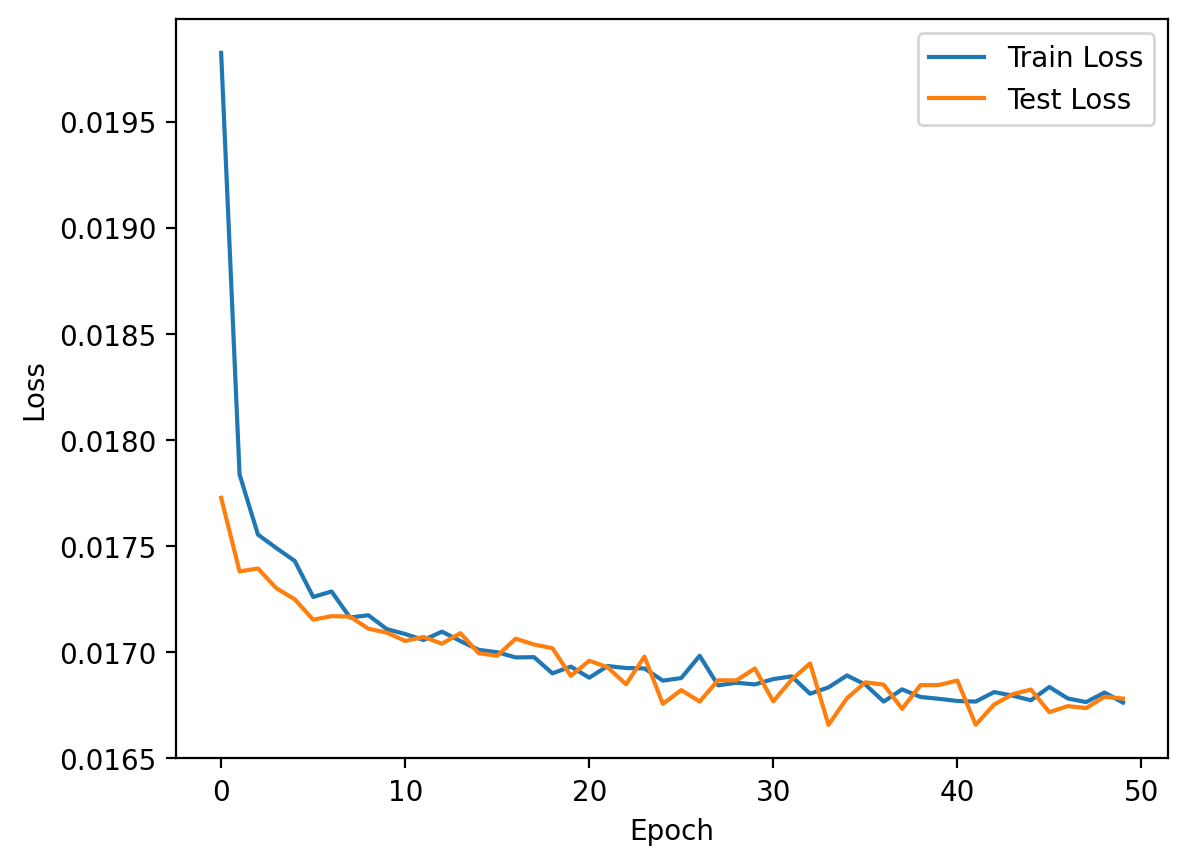

In [ ]:
# @title Melody NN Training Loop

n_epochs = 50
lr = 0.001
lr_lambda = 0.95
K = 16

batch_size = 2048

print(f"INFO: train dataset of size {len(train_set)}, while test set is {len(test_set)}")

melody_train_dataset = MelodyDataset(train_set, dataset_length = 32 * len(train_set), seq_length = 32)
melody_train_loader = DataLoader(melody_train_dataset, batch_size = batch_size, drop_last=True)
melody_test_dataset = MelodyDataset(test_set, dataset_length = 32 * len(test_set), seq_length = 32)
melody_test_loader = DataLoader(melody_test_dataset, batch_size = batch_size, drop_last=True)

# Load the model
model_name = 'VAE_piano_{}'.format(K)
save_path = os.path.join(root_dir, 'Saved Models', 'VAE', 'Large Data', model_name)
piano_vae = ConvVAE(K=K).to(device)
piano_vae.load_state_dict(torch.load(save_path))
piano_vae.eval()

melody_nn = MelodyNN(K = K).to(device)
optimizer = torch.optim.Adam(melody_nn.parameters(), lr = lr)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda = lambda epoch: lr_lambda ** epoch)
criterion = nn.MSELoss()
train_losses, test_losses = training_loop_MelodyNN(piano_vae, melody_nn, optimizer, scheduler, criterion, melody_train_loader, melody_test_loader, n_epochs = n_epochs)

model_name = 'VAE_NN_piano_{}'.format(K)
save_path = os.path.join(root_dir, 'Saved Models', 'VAE', 'Large Data', model_name)
torch.save(melody_nn.state_dict(), save_path)

plt.figure()
plt.plot(train_losses, label = 'Train Loss')
plt.plot(test_losses, label = 'Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# @title Conditional NN Training Functions
from tqdm import tqdm

def run_epoch_VAENN(dataloader, piano_vae, harmony_vae, conditional_nn, optimizer, criterion, is_train = True):
    running_loss = 0
    n_obs = 0

    for piano_seq, past_seq, target_seq in tqdm(dataloader):
      piano_seq = piano_seq / 127.0
      past_seq = past_seq / 127.0
      target_seq = target_seq / 127.0

      piano_seq = piano_seq.to(device)
      past_seq = past_seq.to(device)
      target_seq = target_seq.to(device)

      with torch.no_grad():
        piano_latent = piano_vae.infer(piano_seq.to(device))[:, :-1]
        past_latent = harmony_vae.infer(past_seq.to(device))[:, :-1]
        target_latent = harmony_vae.infer(target_seq.to(device))[:, :-1]

      output_latent = conditional_nn(past_latent.detach(), piano_latent.detach())
      loss = criterion(output_latent, target_latent)

      if is_train == True:
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

      running_loss += loss.item()
      n_obs += piano_seq.size()[0]

    return running_loss / n_obs * 100

def training_loop_VAENN(piano_vae, harmony_vae, conditional_nn, optimizer, scheduler, criterion, train_dataloader, test_dataloader, n_epochs = 50):
  train_losses = []
  test_losses = []

  for epoch in range(1, n_epochs + 1):
    conditional_nn.train()
    print(scheduler.get_last_lr())
    train_epoch_loss = run_epoch_VAENN(train_dataloader, piano_vae, harmony_vae, conditional_nn, optimizer, criterion, is_train = True)
    train_losses.append(train_epoch_loss)
    scheduler.step()
    conditional_nn.eval()
    test_epoch_loss = run_epoch_VAENN(test_dataloader, piano_vae, harmony_vae, conditional_nn, optimizer, criterion, is_train = False)
    test_losses.append(test_epoch_loss)
    print('Epoch {}, Train Loss: {}, Test Loss: {}, Time: {}'.format(epoch, train_epoch_loss, test_epoch_loss, datetime.now()))
  return train_losses, test_losses

guitar
[0.001]


100%|██████████| 50/50 [00:18<00:00,  2.75it/s]


Epoch 1, Train Loss: 0.020143958256443845, Test Loss: 0.01654714602045715, Time: 2024-05-28 09:46:30.079308
[0.00095]


100%|██████████| 50/50 [00:18<00:00,  2.73it/s]


Epoch 2, Train Loss: 0.016334012688160544, Test Loss: 0.01603340418660082, Time: 2024-05-28 09:48:32.762436
[0.0009025]


100%|██████████| 50/50 [00:18<00:00,  2.70it/s]


Epoch 3, Train Loss: 0.015938550905688523, Test Loss: 0.015795044280821458, Time: 2024-05-28 09:50:35.529535
[0.000857375]


100%|██████████| 50/50 [00:18<00:00,  2.68it/s]


Epoch 4, Train Loss: 0.01577032617974574, Test Loss: 0.015802253008587286, Time: 2024-05-28 09:52:39.164730
[0.0008145062499999999]


100%|██████████| 50/50 [00:18<00:00,  2.73it/s]


Epoch 5, Train Loss: 0.015661769763207472, Test Loss: 0.015609111898811534, Time: 2024-05-28 09:54:42.365531
[0.0007737809374999998]


100%|██████████| 50/50 [00:18<00:00,  2.75it/s]


Epoch 6, Train Loss: 0.015551510583002671, Test Loss: 0.015544464898994192, Time: 2024-05-28 09:56:45.196763
[0.0007350918906249999]


100%|██████████| 50/50 [00:18<00:00,  2.70it/s]


Epoch 7, Train Loss: 0.015480083572878304, Test Loss: 0.01573478474165313, Time: 2024-05-28 09:58:48.882339
[0.0006983372960937497]


100%|██████████| 50/50 [00:18<00:00,  2.75it/s]


Epoch 8, Train Loss: 0.01545279624672692, Test Loss: 0.015565930225420745, Time: 2024-05-28 10:00:51.854186
[0.0006634204312890623]


100%|██████████| 50/50 [00:18<00:00,  2.73it/s]


Epoch 9, Train Loss: 0.015431382078685616, Test Loss: 0.015461686562048271, Time: 2024-05-28 10:02:55.011532
[0.0006302494097246091]


100%|██████████| 50/50 [00:18<00:00,  2.66it/s]


Epoch 10, Train Loss: 0.015409419913185942, Test Loss: 0.015453893167432398, Time: 2024-05-28 10:04:59.685358
[0.0005987369392383787]


100%|██████████| 50/50 [00:18<00:00,  2.68it/s]


Epoch 11, Train Loss: 0.015382905606291925, Test Loss: 0.015447563026100397, Time: 2024-05-28 10:07:02.800230
[0.0005688000922764596]


100%|██████████| 50/50 [00:18<00:00,  2.68it/s]


Epoch 12, Train Loss: 0.015370199832086397, Test Loss: 0.015542173379799353, Time: 2024-05-28 10:09:05.511228
[0.0005403600876626366]


100%|██████████| 50/50 [00:18<00:00,  2.70it/s]


Epoch 13, Train Loss: 0.015316135224412377, Test Loss: 0.01548116310732439, Time: 2024-05-28 10:11:08.020794
[0.0005133420832795048]


100%|██████████| 50/50 [00:18<00:00,  2.76it/s]


Epoch 14, Train Loss: 0.015358131462511358, Test Loss: 0.01539213879732415, Time: 2024-05-28 10:13:10.917571
[0.00048767497911552955]


100%|██████████| 50/50 [00:18<00:00,  2.74it/s]


Epoch 15, Train Loss: 0.015307208147058986, Test Loss: 0.01548487032414414, Time: 2024-05-28 10:15:13.315720
[0.000463291230159753]


100%|██████████| 50/50 [00:18<00:00,  2.72it/s]


Epoch 16, Train Loss: 0.015281163677442032, Test Loss: 0.015539832413196564, Time: 2024-05-28 10:17:16.050505
[0.00044012666865176535]


100%|██████████| 50/50 [00:18<00:00,  2.72it/s]


Epoch 17, Train Loss: 0.015285916440557806, Test Loss: 0.015444857010152191, Time: 2024-05-28 10:19:19.610028
[0.0004181203352191771]


100%|██████████| 50/50 [00:18<00:00,  2.70it/s]


Epoch 18, Train Loss: 0.015261197870746453, Test Loss: 0.015355739684309812, Time: 2024-05-28 10:21:22.055117
[0.0003972143184582182]


100%|██████████| 50/50 [00:18<00:00,  2.74it/s]


Epoch 19, Train Loss: 0.015293035934339802, Test Loss: 0.015321836894145235, Time: 2024-05-28 10:23:23.817008
[0.00037735360253530727]


100%|██████████| 50/50 [00:18<00:00,  2.71it/s]


Epoch 20, Train Loss: 0.015240600505806048, Test Loss: 0.015436713467352094, Time: 2024-05-28 10:25:25.777378
[0.0003584859224085419]


100%|██████████| 50/50 [00:18<00:00,  2.73it/s]


Epoch 21, Train Loss: 0.015255342262041177, Test Loss: 0.015424888988491148, Time: 2024-05-28 10:27:28.359322
[0.0003405616262881148]


100%|██████████| 50/50 [00:18<00:00,  2.70it/s]


Epoch 22, Train Loss: 0.015240498478434207, Test Loss: 0.015355349256424233, Time: 2024-05-28 10:29:31.148681
[0.000323533544973709]


100%|██████████| 50/50 [00:18<00:00,  2.70it/s]


Epoch 23, Train Loss: 0.015253970313622143, Test Loss: 0.015442670235643163, Time: 2024-05-28 10:31:34.216684
[0.00030735686772502356]


100%|██████████| 50/50 [00:18<00:00,  2.71it/s]


Epoch 24, Train Loss: 0.015192417971852144, Test Loss: 0.015489638957660645, Time: 2024-05-28 10:33:36.573836
[0.0002919890243387724]


100%|██████████| 50/50 [00:18<00:00,  2.75it/s]


Epoch 25, Train Loss: 0.015241311597441074, Test Loss: 0.015279813640518114, Time: 2024-05-28 10:35:38.057746
[0.00027738957312183375]


100%|██████████| 50/50 [00:18<00:00,  2.72it/s]


Epoch 26, Train Loss: 0.015206712026117881, Test Loss: 0.015451339277205989, Time: 2024-05-28 10:37:40.108578
[0.00026352009446574203]


100%|██████████| 50/50 [00:18<00:00,  2.68it/s]


Epoch 27, Train Loss: 0.01519388274509381, Test Loss: 0.015326994645874947, Time: 2024-05-28 10:39:44.079247
[0.00025034408974245495]


100%|██████████| 50/50 [00:18<00:00,  2.72it/s]


Epoch 28, Train Loss: 0.015184904761656685, Test Loss: 0.015310877963202076, Time: 2024-05-28 10:41:47.095769
[0.00023782688525533216]


100%|██████████| 50/50 [00:18<00:00,  2.74it/s]


Epoch 29, Train Loss: 0.015210799218448942, Test Loss: 0.015402718010591345, Time: 2024-05-28 10:43:48.561005
[0.00022593554099256555]


100%|██████████| 50/50 [00:18<00:00,  2.75it/s]


Epoch 30, Train Loss: 0.015196951144517558, Test Loss: 0.015387389867100866, Time: 2024-05-28 10:45:50.224497


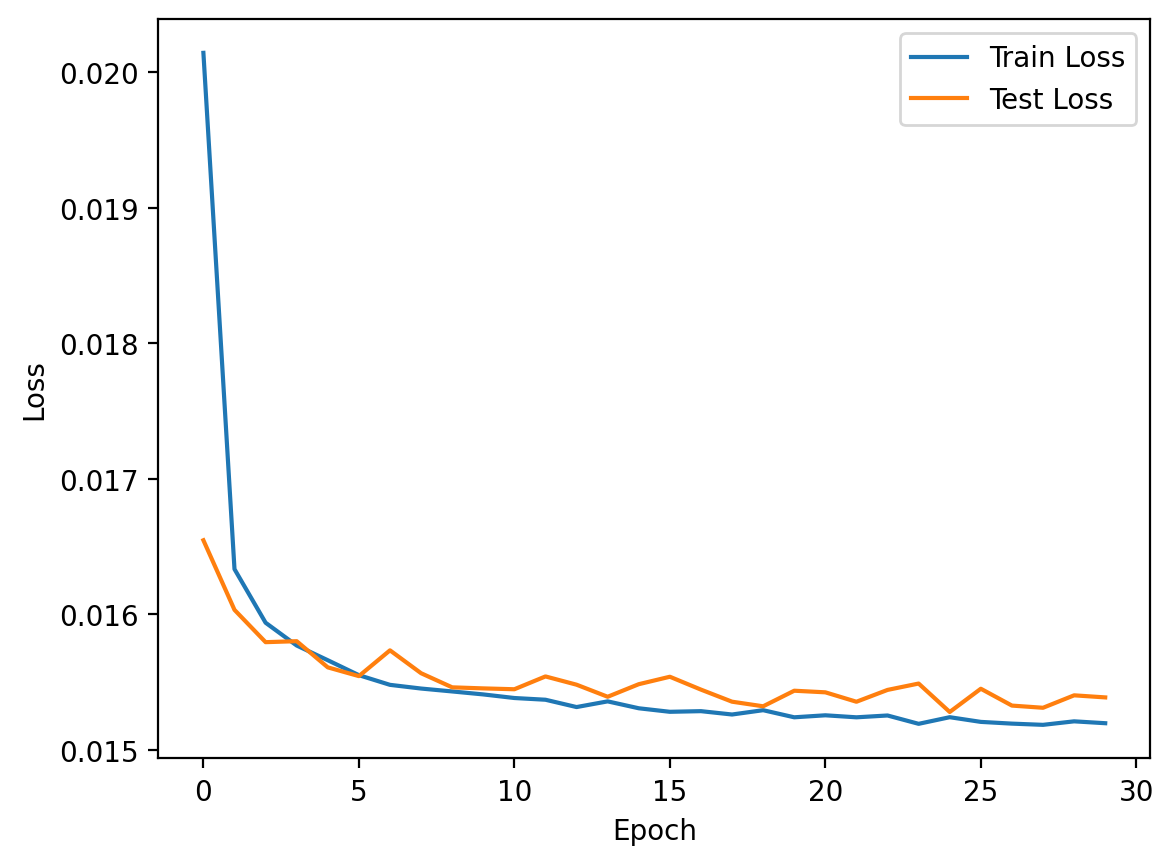

bass
[0.001]


100%|██████████| 50/50 [00:15<00:00,  3.19it/s]


Epoch 1, Train Loss: 0.034573425927845444, Test Loss: 0.03070804016897455, Time: 2024-05-28 10:47:35.754074
[0.00095]


100%|██████████| 50/50 [00:15<00:00,  3.16it/s]


Epoch 2, Train Loss: 0.030674979059537213, Test Loss: 0.02982683602022007, Time: 2024-05-28 10:49:20.229141
[0.0009025]


100%|██████████| 50/50 [00:15<00:00,  3.24it/s]


Epoch 3, Train Loss: 0.0300517091552176, Test Loss: 0.029451346315909174, Time: 2024-05-28 10:51:04.517565
[0.000857375]


100%|██████████| 50/50 [00:15<00:00,  3.20it/s]


Epoch 4, Train Loss: 0.029660421056741795, Test Loss: 0.029211075452622026, Time: 2024-05-28 10:52:49.640774
[0.0008145062499999999]


100%|██████████| 50/50 [00:15<00:00,  3.22it/s]


Epoch 5, Train Loss: 0.02942716255603673, Test Loss: 0.029141595819965005, Time: 2024-05-28 10:54:34.384114
[0.0007737809374999998]


100%|██████████| 50/50 [00:15<00:00,  3.13it/s]


Epoch 6, Train Loss: 0.029318874048456078, Test Loss: 0.02904393058270216, Time: 2024-05-28 10:56:20.486504
[0.0007350918906249999]


100%|██████████| 50/50 [00:15<00:00,  3.16it/s]


Epoch 7, Train Loss: 0.029136244089565645, Test Loss: 0.029013368359301243, Time: 2024-05-28 10:58:06.243672
[0.0006983372960937497]


100%|██████████| 50/50 [00:15<00:00,  3.22it/s]


Epoch 8, Train Loss: 0.02910907995767406, Test Loss: 0.028688022226560864, Time: 2024-05-28 10:59:50.486215
[0.0006634204312890623]


100%|██████████| 50/50 [00:15<00:00,  3.20it/s]


Epoch 9, Train Loss: 0.029009525243169954, Test Loss: 0.028882503393106163, Time: 2024-05-28 11:01:35.276391
[0.0006302494097246091]


100%|██████████| 50/50 [00:15<00:00,  3.20it/s]


Epoch 10, Train Loss: 0.02893170280977231, Test Loss: 0.028788848023395985, Time: 2024-05-28 11:03:20.310038
[0.0005987369392383787]


100%|██████████| 50/50 [00:15<00:00,  3.20it/s]


Epoch 11, Train Loss: 0.028884055524979205, Test Loss: 0.028672039567027238, Time: 2024-05-28 11:05:05.238181
[0.0005688000922764596]


100%|██████████| 50/50 [00:15<00:00,  3.16it/s]


Epoch 12, Train Loss: 0.028864269787986747, Test Loss: 0.02867585967760533, Time: 2024-05-28 11:06:50.674880
[0.0005403600876626366]


100%|██████████| 50/50 [00:15<00:00,  3.15it/s]


Epoch 13, Train Loss: 0.028825026029281473, Test Loss: 0.02872218535048887, Time: 2024-05-28 11:08:36.268253
[0.0005133420832795048]


100%|██████████| 50/50 [00:16<00:00,  3.12it/s]


Epoch 14, Train Loss: 0.028786872731666018, Test Loss: 0.028572016104590148, Time: 2024-05-28 11:10:22.278399
[0.00048767497911552955]


100%|██████████| 50/50 [00:15<00:00,  3.18it/s]


Epoch 15, Train Loss: 0.028713416364732604, Test Loss: 0.02855051017832011, Time: 2024-05-28 11:12:08.015845
[0.000463291230159753]


100%|██████████| 50/50 [00:15<00:00,  3.20it/s]


Epoch 16, Train Loss: 0.02869688486639397, Test Loss: 0.02859079214977101, Time: 2024-05-28 11:13:53.089717
[0.00044012666865176535]


100%|██████████| 50/50 [00:15<00:00,  3.15it/s]


Epoch 17, Train Loss: 0.02868130391555458, Test Loss: 0.02862155082402751, Time: 2024-05-28 11:15:38.407665
[0.0004181203352191771]


100%|██████████| 50/50 [00:15<00:00,  3.19it/s]


Epoch 18, Train Loss: 0.028677678275131947, Test Loss: 0.028593480412382632, Time: 2024-05-28 11:17:24.311114
[0.0003972143184582182]


100%|██████████| 50/50 [00:15<00:00,  3.17it/s]


Epoch 19, Train Loss: 0.02856984603158067, Test Loss: 0.028583402221556756, Time: 2024-05-28 11:19:12.114591
[0.00037735360253530727]


100%|██████████| 50/50 [00:15<00:00,  3.16it/s]


Epoch 20, Train Loss: 0.028606666681196043, Test Loss: 0.028524597175419334, Time: 2024-05-28 11:20:57.112900
[0.0003584859224085419]


100%|██████████| 50/50 [00:15<00:00,  3.18it/s]


Epoch 21, Train Loss: 0.02860389026800092, Test Loss: 0.02854285534704104, Time: 2024-05-28 11:22:42.120146
[0.0003405616262881148]


100%|██████████| 50/50 [00:15<00:00,  3.18it/s]


Epoch 22, Train Loss: 0.028555715476280785, Test Loss: 0.028515548910945654, Time: 2024-05-28 11:24:27.964281
[0.000323533544973709]


100%|██████████| 50/50 [00:15<00:00,  3.19it/s]


Epoch 23, Train Loss: 0.028615094484387517, Test Loss: 0.028541597013827413, Time: 2024-05-28 11:26:13.837814
[0.00030735686772502356]


100%|██████████| 50/50 [00:15<00:00,  3.14it/s]


Epoch 24, Train Loss: 0.028579810670737674, Test Loss: 0.028494741476606574, Time: 2024-05-28 11:27:59.518623
[0.0002919890243387724]


100%|██████████| 50/50 [00:15<00:00,  3.14it/s]


Epoch 25, Train Loss: 0.028530751225049934, Test Loss: 0.028481390967499465, Time: 2024-05-28 11:29:44.940998
[0.00027738957312183375]


100%|██████████| 50/50 [00:15<00:00,  3.17it/s]


Epoch 26, Train Loss: 0.02851487989176694, Test Loss: 0.02844074449967593, Time: 2024-05-28 11:31:30.386751
[0.00026352009446574203]


100%|██████████| 50/50 [00:15<00:00,  3.16it/s]


Epoch 27, Train Loss: 0.02852025312497805, Test Loss: 0.028460485977120697, Time: 2024-05-28 11:33:16.150064
[0.00025034408974245495]


100%|██████████| 50/50 [00:16<00:00,  3.11it/s]


Epoch 28, Train Loss: 0.028527635987930025, Test Loss: 0.028448848461266607, Time: 2024-05-28 11:35:02.872654
[0.00023782688525533216]


100%|██████████| 50/50 [00:16<00:00,  3.11it/s]


Epoch 29, Train Loss: 0.028518867167778655, Test Loss: 0.028484965616371483, Time: 2024-05-28 11:36:50.735709
[0.00022593554099256555]


100%|██████████| 50/50 [00:15<00:00,  3.13it/s]


Epoch 30, Train Loss: 0.028541343738357733, Test Loss: 0.028412473504431546, Time: 2024-05-28 11:38:38.522830


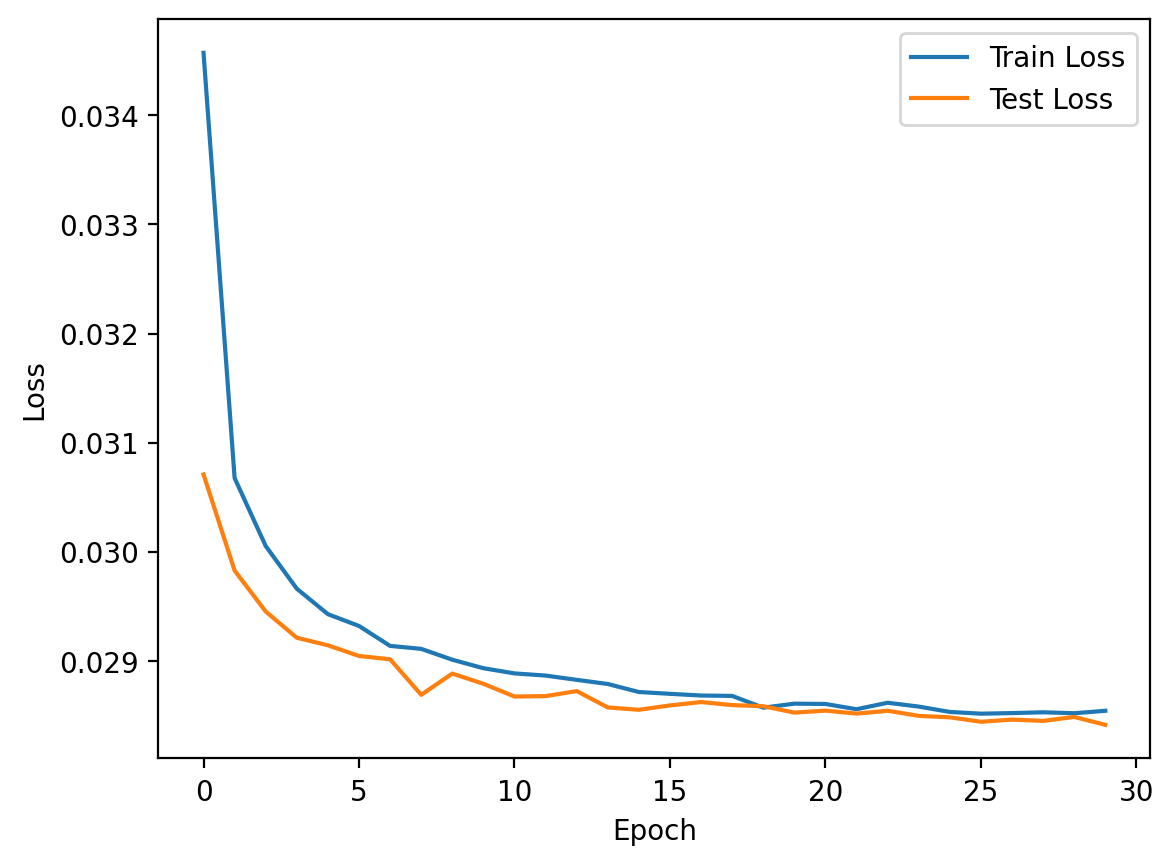

strings
[0.001]


100%|██████████| 50/50 [00:16<00:00,  3.11it/s]


Epoch 1, Train Loss: 0.024292652310129635, Test Loss: 0.020683111273683608, Time: 2024-05-28 11:40:25.146395
[0.00095]


100%|██████████| 50/50 [00:15<00:00,  3.13it/s]


Epoch 2, Train Loss: 0.020637028480873405, Test Loss: 0.020135963859502226, Time: 2024-05-28 11:42:11.228707
[0.0009025]


100%|██████████| 50/50 [00:15<00:00,  3.19it/s]


Epoch 3, Train Loss: 0.020254247073366136, Test Loss: 0.019970883906353265, Time: 2024-05-28 11:43:56.361715
[0.000857375]


100%|██████████| 50/50 [00:15<00:00,  3.21it/s]


Epoch 4, Train Loss: 0.020052572935909806, Test Loss: 0.01982628458063118, Time: 2024-05-28 11:45:41.085310
[0.0008145062499999999]


100%|██████████| 50/50 [00:15<00:00,  3.21it/s]


Epoch 5, Train Loss: 0.01994752385887206, Test Loss: 0.019766749814152718, Time: 2024-05-28 11:47:24.871863
[0.0007737809374999998]


100%|██████████| 50/50 [00:15<00:00,  3.25it/s]


Epoch 6, Train Loss: 0.019962995009362355, Test Loss: 0.019636033423012123, Time: 2024-05-28 11:49:08.918902
[0.0007350918906249999]


100%|██████████| 50/50 [00:15<00:00,  3.24it/s]


Epoch 7, Train Loss: 0.019824107390300463, Test Loss: 0.019690614368300885, Time: 2024-05-28 11:50:53.101428
[0.0006983372960937497]


100%|██████████| 50/50 [00:15<00:00,  3.20it/s]


Epoch 8, Train Loss: 0.019805545822928764, Test Loss: 0.019617724261479452, Time: 2024-05-28 11:52:37.183950
[0.0006634204312890623]


100%|██████████| 50/50 [00:15<00:00,  3.17it/s]


Epoch 9, Train Loss: 0.019739157234115238, Test Loss: 0.019533002836396918, Time: 2024-05-28 11:54:21.747381
[0.0006302494097246091]


100%|██████████| 50/50 [00:15<00:00,  3.17it/s]


Epoch 10, Train Loss: 0.019745350047588532, Test Loss: 0.019488973746774718, Time: 2024-05-28 11:56:06.097886
[0.0005987369392383787]


100%|██████████| 50/50 [00:15<00:00,  3.23it/s]


Epoch 11, Train Loss: 0.019700976871987016, Test Loss: 0.019512224098434672, Time: 2024-05-28 11:57:50.653790
[0.0005688000922764596]


100%|██████████| 50/50 [00:15<00:00,  3.19it/s]


Epoch 12, Train Loss: 0.019687631156813667, Test Loss: 0.01955191433080472, Time: 2024-05-28 11:59:35.452713
[0.0005403600876626366]


100%|██████████| 50/50 [00:15<00:00,  3.15it/s]


Epoch 13, Train Loss: 0.019623638125805472, Test Loss: 0.019512639584718272, Time: 2024-05-28 12:01:20.212119
[0.0005133420832795048]


100%|██████████| 50/50 [00:15<00:00,  3.19it/s]


Epoch 14, Train Loss: 0.019631220011817763, Test Loss: 0.019469985738396645, Time: 2024-05-28 12:03:03.880558
[0.00048767497911552955]


100%|██████████| 50/50 [00:15<00:00,  3.18it/s]


Epoch 15, Train Loss: 0.019648595095954798, Test Loss: 0.019566821225453168, Time: 2024-05-28 12:04:47.762725
[0.000463291230159753]


100%|██████████| 50/50 [00:15<00:00,  3.23it/s]


Epoch 16, Train Loss: 0.01962451507853062, Test Loss: 0.019482012517983094, Time: 2024-05-28 12:06:31.639329
[0.00044012666865176535]


100%|██████████| 50/50 [00:15<00:00,  3.21it/s]


Epoch 17, Train Loss: 0.019580392667271105, Test Loss: 0.019448723061941564, Time: 2024-05-28 12:08:15.877117
[0.0004181203352191771]


100%|██████████| 50/50 [00:15<00:00,  3.23it/s]


Epoch 18, Train Loss: 0.019589717319345064, Test Loss: 0.019417286821408197, Time: 2024-05-28 12:09:59.689872
[0.0003972143184582182]


100%|██████████| 50/50 [00:15<00:00,  3.23it/s]


Epoch 19, Train Loss: 0.019577136502025687, Test Loss: 0.019499310670653358, Time: 2024-05-28 12:11:43.724943
[0.00037735360253530727]


100%|██████████| 50/50 [00:15<00:00,  3.18it/s]


Epoch 20, Train Loss: 0.019582173591118936, Test Loss: 0.019388241198612377, Time: 2024-05-28 12:13:27.562764
[0.0003584859224085419]


100%|██████████| 50/50 [00:15<00:00,  3.20it/s]


Epoch 21, Train Loss: 0.019577668953529546, Test Loss: 0.0194165414723102, Time: 2024-05-28 12:15:11.252143
[0.0003405616262881148]


100%|██████████| 50/50 [00:15<00:00,  3.21it/s]


Epoch 22, Train Loss: 0.019553165582974416, Test Loss: 0.019473060820018873, Time: 2024-05-28 12:16:55.060427
[0.000323533544973709]


100%|██████████| 50/50 [00:15<00:00,  3.22it/s]


Epoch 23, Train Loss: 0.019584174530701975, Test Loss: 0.01949997345218435, Time: 2024-05-28 12:18:38.703152
[0.00030735686772502356]


100%|██████████| 50/50 [00:15<00:00,  3.21it/s]


Epoch 24, Train Loss: 0.01952471344774379, Test Loss: 0.019454066350590438, Time: 2024-05-28 12:20:22.551639
[0.0002919890243387724]


100%|██████████| 50/50 [00:15<00:00,  3.22it/s]


Epoch 25, Train Loss: 0.019525335875174202, Test Loss: 0.019325218570884317, Time: 2024-05-28 12:22:06.606622
[0.00027738957312183375]


100%|██████████| 50/50 [00:15<00:00,  3.18it/s]


Epoch 26, Train Loss: 0.019533309709849688, Test Loss: 0.019488733436446637, Time: 2024-05-28 12:23:50.776039
[0.00026352009446574203]


100%|██████████| 50/50 [00:15<00:00,  3.19it/s]


Epoch 27, Train Loss: 0.019529165191170893, Test Loss: 0.01933759535313584, Time: 2024-05-28 12:25:34.943357
[0.00025034408974245495]


100%|██████████| 50/50 [00:15<00:00,  3.23it/s]


Epoch 28, Train Loss: 0.019551569022669482, Test Loss: 0.019422987301368266, Time: 2024-05-28 12:27:18.647624
[0.00023782688525533216]


100%|██████████| 50/50 [00:15<00:00,  3.20it/s]


Epoch 29, Train Loss: 0.019501546019865333, Test Loss: 0.019422032230067998, Time: 2024-05-28 12:29:02.441725
[0.00022593554099256555]


100%|██████████| 50/50 [00:15<00:00,  3.24it/s]


Epoch 30, Train Loss: 0.019538814520043597, Test Loss: 0.019433917565038428, Time: 2024-05-28 12:30:46.269841


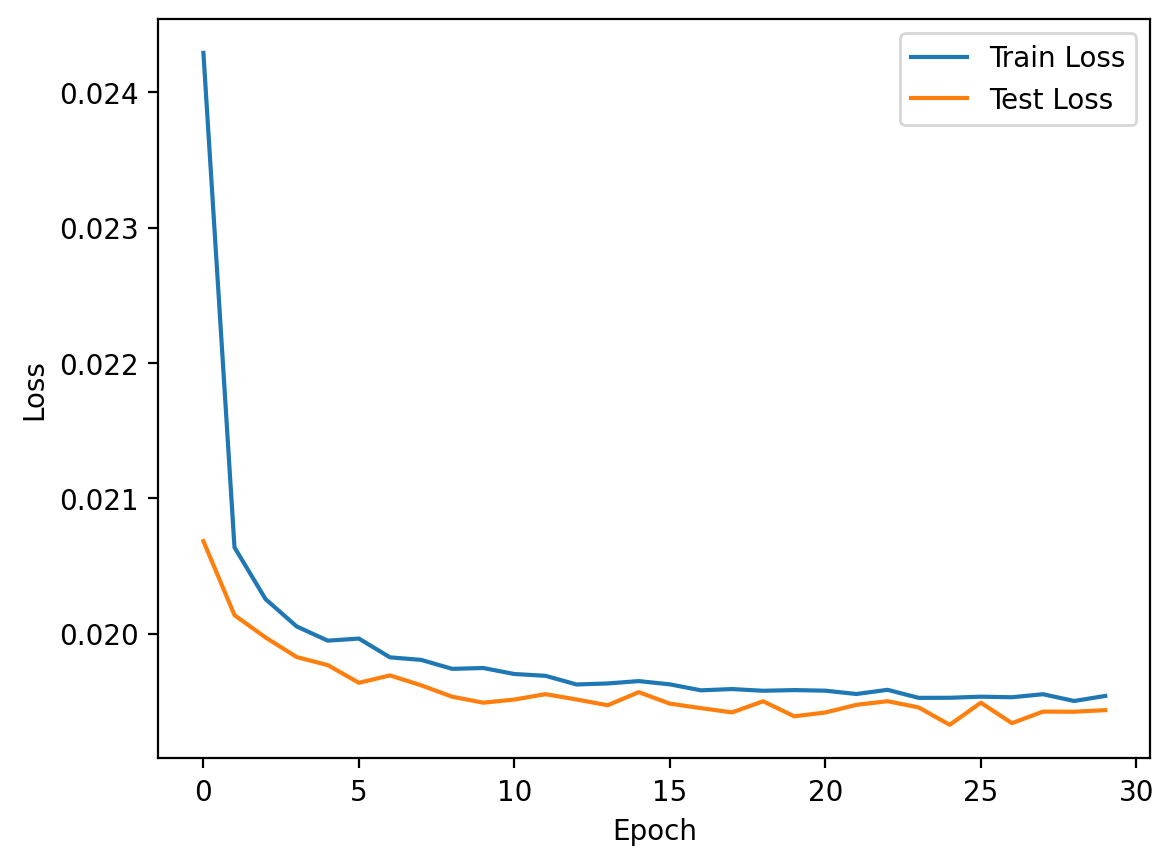

drums
[0.001]


100%|██████████| 50/50 [00:14<00:00,  3.40it/s]


Epoch 1, Train Loss: 0.01058190971274547, Test Loss: 0.006826314216596074, Time: 2024-05-28 12:32:26.885012
[0.00095]


100%|██████████| 50/50 [00:14<00:00,  3.34it/s]


Epoch 2, Train Loss: 0.006553703723780722, Test Loss: 0.0065894732615561225, Time: 2024-05-28 12:34:06.854464
[0.0009025]


100%|██████████| 50/50 [00:15<00:00,  3.33it/s]


Epoch 3, Train Loss: 0.00641970621818729, Test Loss: 0.0065041656052926555, Time: 2024-05-28 12:35:46.916017
[0.000857375]


100%|██████████| 50/50 [00:14<00:00,  3.36it/s]


Epoch 4, Train Loss: 0.006312088544931817, Test Loss: 0.006482791846792679, Time: 2024-05-28 12:37:26.877525
[0.0008145062499999999]


100%|██████████| 50/50 [00:14<00:00,  3.37it/s]


Epoch 5, Train Loss: 0.00625174962793531, Test Loss: 0.006459097028709948, Time: 2024-05-28 12:39:06.626608
[0.0007737809374999998]


100%|██████████| 50/50 [00:14<00:00,  3.35it/s]


Epoch 6, Train Loss: 0.006261471339776493, Test Loss: 0.00631685544794891, Time: 2024-05-28 12:40:46.993512
[0.0007350918906249999]


100%|██████████| 50/50 [00:15<00:00,  3.30it/s]


Epoch 7, Train Loss: 0.006190015261689067, Test Loss: 0.006324518872133923, Time: 2024-05-28 12:42:27.717918
[0.0006983372960937497]


100%|██████████| 50/50 [00:15<00:00,  3.28it/s]


Epoch 8, Train Loss: 0.006168824986904749, Test Loss: 0.0063641943779657595, Time: 2024-05-28 12:44:10.057235
[0.0006634204312890623]


100%|██████████| 50/50 [00:15<00:00,  3.24it/s]


Epoch 9, Train Loss: 0.006188272723641565, Test Loss: 0.006316662227618509, Time: 2024-05-28 12:45:52.625054
[0.0006302494097246091]


100%|██████████| 50/50 [00:15<00:00,  3.22it/s]


Epoch 10, Train Loss: 0.006150744154093816, Test Loss: 0.0062840988975949585, Time: 2024-05-28 12:47:35.011647
[0.0005987369392383787]


100%|██████████| 50/50 [00:15<00:00,  3.30it/s]


Epoch 11, Train Loss: 0.006119785483489568, Test Loss: 0.006291827143286356, Time: 2024-05-28 12:49:17.253345
[0.0005688000922764596]


100%|██████████| 50/50 [00:15<00:00,  3.29it/s]


Epoch 12, Train Loss: 0.006105194032142221, Test Loss: 0.006270020647207275, Time: 2024-05-28 12:50:58.940671
[0.0005403600876626366]


100%|██████████| 50/50 [00:15<00:00,  3.32it/s]


Epoch 13, Train Loss: 0.006135211332176868, Test Loss: 0.006306154587946366, Time: 2024-05-28 12:52:40.642163
[0.0005133420832795048]


100%|██████████| 50/50 [00:14<00:00,  3.39it/s]


Epoch 14, Train Loss: 0.006130806175374154, Test Loss: 0.006291486766713206, Time: 2024-05-28 12:54:21.026059
[0.00048767497911552955]


100%|██████████| 50/50 [00:15<00:00,  3.30it/s]


Epoch 15, Train Loss: 0.006095979003642332, Test Loss: 0.0062560005026170975, Time: 2024-05-28 12:56:01.787344
[0.000463291230159753]


100%|██████████| 50/50 [00:15<00:00,  3.30it/s]


Epoch 16, Train Loss: 0.006075603374791197, Test Loss: 0.0062765593465883285, Time: 2024-05-28 12:57:41.532341
[0.00044012666865176535]


100%|██████████| 50/50 [00:14<00:00,  3.37it/s]


Epoch 17, Train Loss: 0.006054123432349256, Test Loss: 0.00621506472089095, Time: 2024-05-28 12:59:22.036530
[0.0004181203352191771]


100%|██████████| 50/50 [00:15<00:00,  3.31it/s]


Epoch 18, Train Loss: 0.006083719002252648, Test Loss: 0.006270472542382777, Time: 2024-05-28 13:01:02.860607
[0.0003972143184582182]


100%|██████████| 50/50 [00:15<00:00,  3.33it/s]


Epoch 19, Train Loss: 0.006081017695386192, Test Loss: 0.006266059142944869, Time: 2024-05-28 13:02:43.770736
[0.00037735360253530727]


100%|██████████| 50/50 [00:15<00:00,  3.32it/s]


Epoch 20, Train Loss: 0.006067056698080244, Test Loss: 0.006290401332080364, Time: 2024-05-28 13:04:24.643827
[0.0003584859224085419]


100%|██████████| 50/50 [00:15<00:00,  3.31it/s]


Epoch 21, Train Loss: 0.006064985925956829, Test Loss: 0.006258497618546245, Time: 2024-05-28 13:06:05.433483
[0.0003405616262881148]


100%|██████████| 50/50 [00:14<00:00,  3.35it/s]


Epoch 22, Train Loss: 0.006068024908991376, Test Loss: 0.006239764566998928, Time: 2024-05-28 13:07:45.554149
[0.000323533544973709]


100%|██████████| 50/50 [00:14<00:00,  3.38it/s]


Epoch 23, Train Loss: 0.006067247561307814, Test Loss: 0.0062180793975130655, Time: 2024-05-28 13:09:25.510052
[0.00030735686772502356]


100%|██████████| 50/50 [00:14<00:00,  3.36it/s]


Epoch 24, Train Loss: 0.006051038217521355, Test Loss: 0.0062899098338675685, Time: 2024-05-28 13:11:05.473334
[0.0002919890243387724]


100%|██████████| 50/50 [00:14<00:00,  3.35it/s]


Epoch 25, Train Loss: 0.006078309642887202, Test Loss: 0.006223513504664879, Time: 2024-05-28 13:12:45.267687
[0.00027738957312183375]


100%|██████████| 50/50 [00:14<00:00,  3.38it/s]


Epoch 26, Train Loss: 0.00605853727674784, Test Loss: 0.0062453089994960465, Time: 2024-05-28 13:14:25.420290
[0.00026352009446574203]


100%|██████████| 50/50 [00:14<00:00,  3.35it/s]


Epoch 27, Train Loss: 0.00604379199141707, Test Loss: 0.0062157805150491185, Time: 2024-05-28 13:16:05.307076
[0.00025034408974245495]


100%|██████████| 50/50 [00:14<00:00,  3.36it/s]


Epoch 28, Train Loss: 0.006045429625015125, Test Loss: 0.006296723382547499, Time: 2024-05-28 13:17:44.970885
[0.00023782688525533216]


100%|██████████| 50/50 [00:14<00:00,  3.34it/s]


Epoch 29, Train Loss: 0.006053452961821958, Test Loss: 0.006282639042183291, Time: 2024-05-28 13:19:24.961065
[0.00022593554099256555]


100%|██████████| 50/50 [00:14<00:00,  3.38it/s]


Epoch 30, Train Loss: 0.006022581840971071, Test Loss: 0.006232727013411931, Time: 2024-05-28 13:21:04.645811


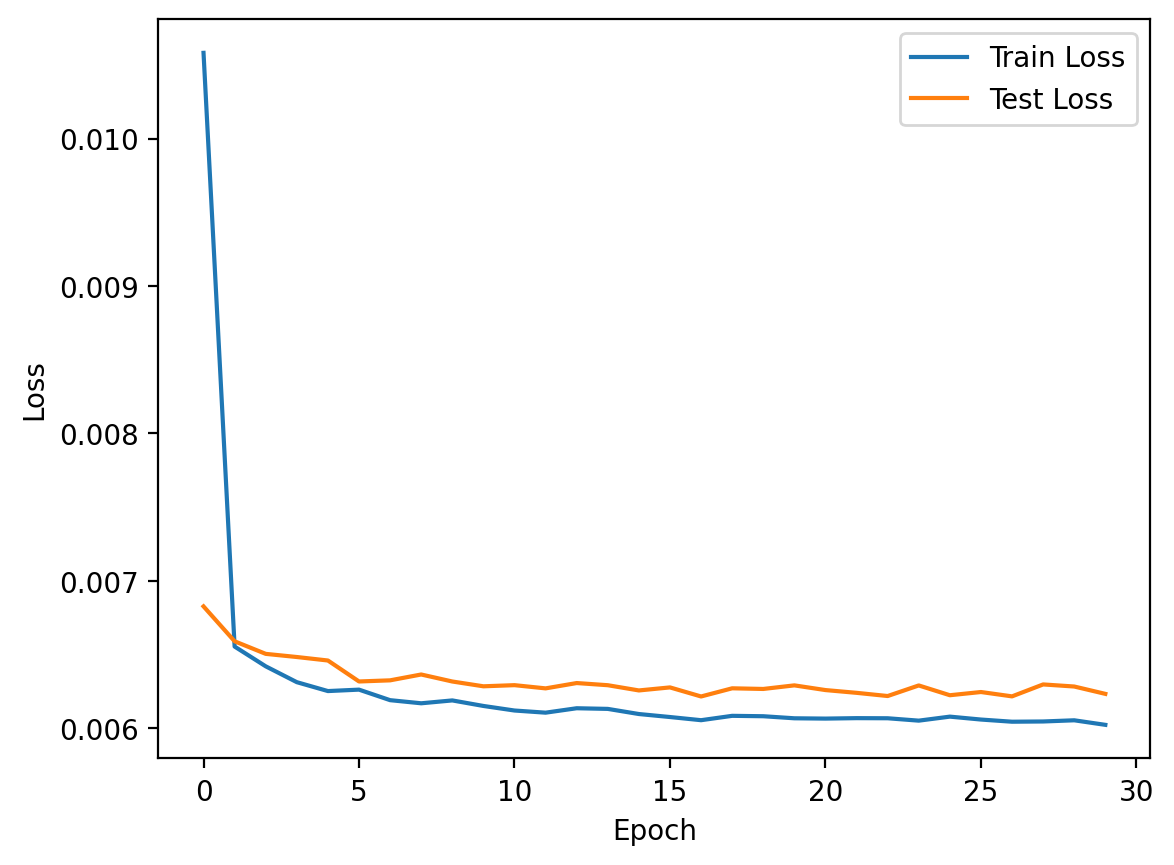

In [ ]:
# @title Conditional NN Training Loop

n_epochs = 30
lr = 0.001
lr_lambda = 0.95
K = 16

batch_size = 2048

for instrument in ['guitar', 'bass', 'strings', 'drums']:
  print(instrument)

  cond_train_dataset = ConditionalDataset(train_set, dataset_length = 32 * len(train_set), seq_length = 32, instrument = instrument)
  cond_train_loader = DataLoader(cond_train_dataset, batch_size = batch_size, drop_last=True)
  cond_test_dataset = ConditionalDataset(test_set, dataset_length = 32 * len(test_set), seq_length = 32, instrument = instrument)
  cond_test_loader = DataLoader(cond_test_dataset, batch_size = batch_size, drop_last=True)

  # Load the model
  model_name = 'VAE_{}_{}'.format(instrument, K)
  save_path = os.path.join(root_dir, 'Saved Models', 'VAE', 'Large Data', model_name)
  harmony_vae = ConvVAE(K=K).to(device)
  harmony_vae.load_state_dict(torch.load(save_path))
  harmony_vae.eval()

  conditional_nn = ConditionalNN(K = K).to(device)
  optimizer = torch.optim.Adam(conditional_nn.parameters(), lr = lr)
  scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda = lambda epoch: lr_lambda ** epoch)
  criterion = nn.MSELoss()
  train_losses, test_losses = training_loop_VAENN(piano_vae, harmony_vae, conditional_nn, optimizer, scheduler, criterion, cond_train_loader, cond_test_loader, n_epochs = n_epochs)

  model_name = 'VAE_NN_{}_{}'.format(instrument, K)
  save_path = os.path.join(root_dir, 'Saved Models', 'VAE','Large Data', model_name)
  torch.save(conditional_nn.state_dict(), save_path)

  plt.figure()
  plt.plot(train_losses, label = 'Train Loss')
  plt.plot(test_losses, label = 'Test Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

### Using Trained VAEs and NNs to Generate Music

In [ ]:
# @title Load trained VAEs and NNs (Run me)

# Specify dimensionality of VAEs you want (K = 8, 16, 32, 64)
K = 16

# Load VAEs
model_name = 'VAE_piano_{}'.format(K)
save_path = os.path.join(root_dir, 'Saved Models', 'VAE', 'Large Data', model_name)
piano_vae = ConvVAE(K=K).to(device)
piano_vae.load_state_dict(torch.load(save_path))
piano_vae.eval()

model_name = 'VAE_guitar_{}'.format(K)
save_path = os.path.join(root_dir, 'Saved Models', 'VAE', 'Large Data', model_name)
guitar_vae = ConvVAE(K=K).to(device)
guitar_vae.load_state_dict(torch.load(save_path))
guitar_vae.eval()

model_name = 'VAE_bass_{}'.format(K)
save_path = os.path.join(root_dir, 'Saved Models', 'VAE', 'Large Data', model_name)
bass_vae = ConvVAE(K=K).to(device)
bass_vae.load_state_dict(torch.load(save_path))
bass_vae.eval()

model_name = 'VAE_strings_{}'.format(K)
save_path = os.path.join(root_dir, 'Saved Models', 'VAE', 'Large Data', model_name)
strings_vae = ConvVAE(K=K).to(device)
strings_vae.load_state_dict(torch.load(save_path))
strings_vae.eval()

# Load Melody NN
model_name = 'VAE_NN_piano_{}'.format(K)
save_path = os.path.join(root_dir, 'Saved Models', 'VAE', 'Large Data', model_name)
melody_nn = MelodyNN(K = K).to(device)
melody_nn.load_state_dict(torch.load(save_path))
melody_nn.eval()

# Load Conditional NNs
model_name = 'VAE_NN_guitar_{}'.format(K)
save_path = os.path.join(root_dir, 'Saved Models', 'VAE', 'Large Data', model_name)
guitar_nn = ConditionalNN(K = K).to(device)
guitar_nn.load_state_dict(torch.load(save_path))
guitar_nn.eval()

model_name = 'VAE_NN_bass_{}'.format(K)
save_path = os.path.join(root_dir, 'Saved Models', 'VAE', 'Large Data', model_name)
bass_nn = ConditionalNN(K = K).to(device)
bass_nn.load_state_dict(torch.load(save_path))
guitar_nn.eval()

model_name = 'VAE_NN_strings_{}'.format(K)
save_path = os.path.join(root_dir, 'Saved Models', 'VAE', 'Large Data', model_name)
strings_nn = ConditionalNN(K = K).to(device)
strings_nn.load_state_dict(torch.load(save_path))
strings_nn.eval()

model_name = 'VAE_NN_drums_{}'.format(K)
save_path = os.path.join(root_dir, 'Saved Models', 'VAE', 'Large Data', model_name)
drums_nn = ConditionalNN(K = K).to(device)
drums_nn.load_state_dict(torch.load(save_path))
drums_nn.eval()

ConditionalNN(
  (fc1): Linear(in_features=32, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=16, bias=True)
)

In [ ]:
# @title Generation Dataset

# all fields cannot be blank
class GenerationDataset(Dataset):
  def __init__(self, list_of_sequences, dataset_length = 32 * 10000, seq_length = 50):

    # Don't normalize anymore since it was done earlier
    self.data = list_of_sequences
    self.n_songs = len(list_of_sequences)
    self.seq_length = seq_length
    self.length = dataset_length

  def __getitem__(self, index):

    valid_sequence = False
    while valid_sequence == False:
      # Choose a random song id
      song_id = random.randint(0, self.n_songs - 1)
      song_length = self.data[song_id].size()[1]
      # Choose a random start window
      start_time = random.randint(0, song_length - self.seq_length * 2 - 2)
      start_time = start_time - (start_time % 32)
      # Check that every track is not empty
      piano_sequence = self.data[song_id][0, start_time:(start_time + self.seq_length), :]
      guitar_sequence = self.data[song_id][1, start_time:(start_time + self.seq_length), :]
      bass_sequence = self.data[song_id][2, start_time:(start_time + self.seq_length), :]
      strings_sequence = self.data[song_id][3, start_time:(start_time + self.seq_length), :]
      drums_sequence = self.data[song_id][4, start_time:(start_time + self.seq_length), :]

      if piano_sequence.sum() != 0 and guitar_sequence.sum() != 0 and bass_sequence.sum() != 0 \
      and strings_sequence.sum() != 0 and drums_sequence.sum() != 0:
        valid_sequence = True
      else:
        if random.random() < 0.1:
          valid_sequence = True

    train_sequence = self.data[song_id][:, start_time:(start_time + self.seq_length), :]
    target_sequence = self.data[song_id][:, (start_time + self.seq_length):(start_time + self.seq_length * 2), :]
    return train_sequence, target_sequence

  def __len__(self):
    return self.length

In [ ]:
# Create dataset and dataloader that gives entire multitrack chunks of music
gen_dataset = GenerationDataset(pianorolls_list, dataset_length = 32 * len(pianorolls_list), seq_length = 32)
gen_loader = DataLoader(gen_dataset, batch_size = 32, drop_last=True)

In [ ]:
train, test = next(iter(gen_loader))
sample = train[0, :, :, :]
# sample is a 5 x 32 x 128

In [ ]:
# Function that takes in previous length-32 5-instrument sequence, and generates a new length-32 5-instrument sequence
# Input_sequence: 5 x 32 x 128, vae_models: 5-tuple of the trained VAEs, nn_models: 5-tuple of trained NNs
# threshold as a % of the maximum output that we will keep the notes there (those under threshold will be moved to 0)
# if binarize = True, will set all remaining non-zero to max intensity
def generate_music_vae(sample, vae_models, nn_models, noise_sd = 0, threshold = 0.3, binarize = True):

  piano_vae, guitar_vae, bass_vae, strings_vae, drums_vae = vae_models
  melody_nn, guitar_nn, bass_nn, strings_nn, drums_nn = nn_models

  sample = sample / 127.0
  piano, guitar, bass, strings, drums = sample[0, :, :], sample[1, :, :], sample[2, :, :], sample[3, :, :], sample[4, :, :]

  # Convert all part from image space to latent space - {instr}_latent: batch_size x K
  piano_latent = piano_vae.infer(piano.unsqueeze(0).to(device))[:, :-1]
  guitar_latent = guitar_vae.infer(guitar.unsqueeze(0).to(device))[:, :-1]
  bass_latent = bass_vae.infer(bass.unsqueeze(0).to(device))[:, :-1]
  strings_latent = strings_vae.infer(strings.unsqueeze(0).to(device))[:, :-1]
  drums_latent = drums_vae.infer(drums.unsqueeze(0).to(device))[:, :-1]

  # Use melody NN to convert past piano latent to next piano latent - piano_next_latent: batch_size x K
  piano_next_latent = melody_nn(piano_latent)
  # Add some noise
  random_noise = torch.randn_like(piano_next_latent) * noise_sd
  piano_next_latent = piano_next_latent + random_noise

  # Use conditional NNs to convert piano latent to instrument latent, and add noise - {istr})_next_latent: batch_size x K
  guitar_next_latent = guitar_nn(guitar_latent, piano_next_latent) + torch.randn_like(piano_next_latent) * noise_sd
  bass_next_latent = bass_nn(bass_latent, piano_next_latent) + torch.randn_like(piano_next_latent) * noise_sd
  strings_next_latent = strings_nn(strings_latent, piano_next_latent) + torch.randn_like(piano_next_latent) * noise_sd
  drums_next_latent = drums_nn(drums_latent, piano_next_latent) + torch.randn_like(piano_next_latent) * noise_sd

  # Generate new samples given new latent
  piano_next = piano_vae.generate(piano_next_latent.unsqueeze(0)).view(1, 32, 128)
  guitar_next = guitar_vae.generate(guitar_next_latent.unsqueeze(0)).view(1, 32, 128)
  bass_next = bass_vae.generate(bass_next_latent.unsqueeze(0)).view(1, 32, 128)
  strings_next = strings_vae.generate(strings_next_latent.unsqueeze(0)).view(1, 32, 128)
  drums_next = drums_vae.generate(drums_next_latent.unsqueeze(0)).view(1, 32, 128)

  creation = torch.cat((piano_next, guitar_next, bass_next, strings_next, drums_next), dim = 0)
  creation[creation < threshold] = 0

  if binarize == True:
    creation[creation > 0] = 0.8

    # Quieten the strings
    creation[3, :, :] = creation[3, :, :] * 0.75

  return creation

In [ ]:
vae_models = (piano_vae, guitar_vae, bass_vae, strings_vae, drums_vae)
nn_models = (melody_nn, guitar_nn, bass_nn, strings_nn, drums_nn)

# Code to essentially recurrently generate music
prediction_steps = 10
generated_track = torch.zeros((5, 32 * (prediction_steps + 1), 128)).to(device)
generated_track[:, :32, :] = sample

for i in range(1, prediction_steps + 1):
  sample = generate_music_vae(sample, vae_models, nn_models, noise_sd = 1, threshold = 0.3, binarize = True)
  generated_track[:,32*i:32*(i+1) , :] = sample

[<Axes: xlabel='time (beat)', ylabel='Piano\n\npitch'>,
 <Axes: xlabel='time (beat)', ylabel='Guitar\n\npitch'>,
 <Axes: xlabel='time (beat)', ylabel='Bass\n\npitch'>,
 <Axes: xlabel='time (beat)', ylabel='Strings\n\npitch'>,
 <Axes: xlabel='time (beat)', ylabel='Drums\n\npitch'>]

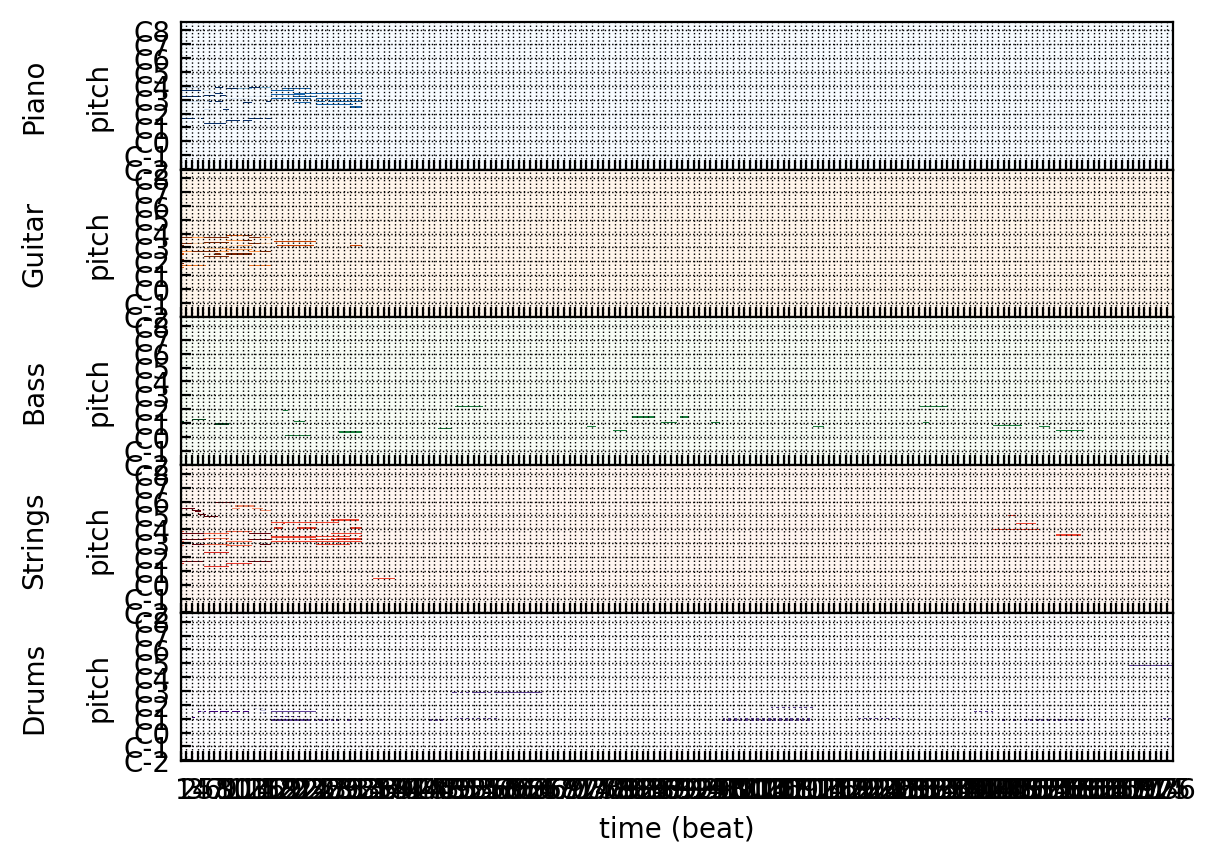

In [ ]:
# Only un-normalize here
generated_track_out = generated_track * 127
# Convert predictions into the multitrack pianoroll
piano_track = pypianoroll.StandardTrack(name = 'Piano', program = 0, is_drum = False, pianoroll = generated_track_out[0, :, :].detach().cpu().numpy())
guitar_track = pypianoroll.StandardTrack(name = 'Guitar', program = 24, is_drum = False, pianoroll = generated_track_out[1, :, :].detach().cpu().numpy())
bass_track = pypianoroll.StandardTrack(name = 'Bass', program = 32, is_drum = False, pianoroll = generated_track_out[2, :, :].cpu().detach().numpy())
strings_track = pypianoroll.StandardTrack(name = 'Strings', program = 48, is_drum = False, pianoroll = generated_track_out[3, :, :].cpu().detach().numpy())
drums_track = pypianoroll.StandardTrack(name = 'Drums', is_drum = True, pianoroll = generated_track_out[4, :, :].cpu().detach().numpy())
generated_multitrack = pypianoroll.Multitrack(name = 'Generated', resolution = 2, tracks = [piano_track, guitar_track, bass_track, strings_track, drums_track])
generated_multitrack.plot()

In [ ]:
generated_pm = pypianoroll.to_pretty_midi(generated_multitrack)

In [ ]:
generated_path = os.path.join(root_dir, 'GeneratedMidiFromVAE', 'vae_nuovo_training.mid')
pypianoroll.write(generated_path, generated_multitrack)